Jupyter is a computing environment supporting several interpreted programming languages, cell-by-cell execution, and inline output, including rich tables and charts. It is most often paired with python. It is ideal for quick, iterative data exploration and visualization. All tools and libraries used in this short demonstration are free and open-source.

The complete code can be run by pressing the following button:

<img src="img/RunAll.png" width=800/>

In case the contents of a single cell are changed later, the cell alone can be rerun with the following button. Remeber to also rerun cells whose contents are based on what was just changed. (So perhaps even rerun everything)

<img src="img/RunCell.png" width=800/>

# Simulation
First we import a few libaries

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as col
import pandas as pd
import math
import numpy as np
import scipy.integrate as integrate

Then we define how strongly the desire to drive fast and the desire to drive efficient are wighted in our optimization. Only the other will be optimized if either is 0.

In [19]:
factor_time = 0.2
factor_efficiency = 0.8

In [20]:
G = nx.DiGraph()
G.add_node("x0_k0",v=0) #add start node
coordinate_set_dict = {"x0_k0": (0,0)}

Now to the heart of the simulation: the assumptions taken for modelling. The following list defines the constants that we use to model the car.

In [21]:
g = 9.81                    # [m/s^2] earth gravity constant


# Mechanical model of the car with the following constants:
driver_mass = 71            # [kg]   mass of the driver
car_mass = 123 + driver_mass# [kg]   weight of car and driver
diameter_tire = 0.4         # [m]    diameter of the tire
coeff_roll_res = 0.02       # [1]    Unitless roll resistance coefficient, the real value is possibly lower
gear_ratio = 5              # [1]    Unitless ratio of how many rotations the motor has to do for one roation of the wheel
coeff_aero_drag = 0.2       # [1]    Unitless aerodynamic Drag coefficient
A_aero = 0.8                # [m^2]  Aerodynamic front surface of the car
rho_air = 1.225             # [kg/m^3] Density of air at standard conditions 


# Battery electric car simulated by a model of series wound dc motor model with the follwing constants:
torque_max = 3.6            # [Nm] Engine maximum torque
torque_constant = 0.130     # [N*m/A]
velocity_constant = 70      # [1/(min * V)]
anchor_resistance = 0.1     # [Ohm]
torque_loss = 0.5           # [N*m]


We now define the states states car is allowed to be in. For this we define a track profile using waypoints that we then interpolate. Change the waypoints in order to change the Track

In [22]:
section_length = 50         # [m]     distance resolution
velocity_spacing = 2.5      # [km/h]  velocity resolution of the simulation
max_acceleration = 3        # [1]     Unitless integer of how many velocity_spacing steps the car can accelerate or deaccelerte over one section_length

# Define the track profile using waypoints 
# Between waypoints missing the values are obtained with linear interpolation
waypoints = [
    {"s": 0,    "vmax": 0,  "vmin": 0,  "m_above_sea": 100}, # waypoint at start of track needed
    {"s": 50,   "vmax": 30, "vmin": 5, "m_above_sea": 101},
    {"s": 100,  "vmax": 50, "vmin": 10, "m_above_sea": 101},
    {"s": 500,  "vmax": 50, "vmin": 20, "m_above_sea": 101},
    {"s": 550,  "vmax": 50, "vmin": 20, "m_above_sea": 103},
    {"s": 600,  "vmax": 50, "vmin": 20, "m_above_sea": 107},
    {"s": 750,  "vmax": 50, "vmin": 20, "m_above_sea": 103},
    {"s": 850,  "vmax": 50, "vmin": 20, "m_above_sea": 100},
    {"s": 1599, "vmax": 50, "vmin": 0,  "m_above_sea": 100}, # allow speed to drop again before the end
    {"s": 1600, "vmax": 0,  "vmin": 0 , "m_above_sea": 100}  # waypoint at end of track needed
]

# Create the full track profile out of the waypoints above
waypoint_df = pd.DataFrame(waypoints).set_index("s").sort_index()
s_range = np.arange(waypoint_df.index.min(), waypoint_df.index.max() + 1, section_length)
config = waypoint_df.reindex(waypoint_df.index.union(s_range)).sort_index().interpolate("index").loc[s_range]
config = config.reset_index()


x_max = len(config.index)-1  # index of the end of the last section

# Helper fuction to calculate the Gradient angle inside section x-1
def get_gradient_angle(x):
    return math.atan( (config.loc[x, "m_above_sea"]-config.loc[x-1, "m_above_sea"] ) / section_length)   #in rad

print(config)

       s  vmax       vmin  m_above_sea
0      0   0.0   0.000000   100.000000
1     50  30.0   5.000000   101.000000
2    100  50.0  10.000000   101.000000
3    150  50.0  11.250000   101.000000
4    200  50.0  12.500000   101.000000
5    250  50.0  13.750000   101.000000
6    300  50.0  15.000000   101.000000
7    350  50.0  16.250000   101.000000
8    400  50.0  17.500000   101.000000
9    450  50.0  18.750000   101.000000
10   500  50.0  20.000000   101.000000
11   550  50.0  20.000000   103.000000
12   600  50.0  20.000000   107.000000
13   650  50.0  20.000000   105.666667
14   700  50.0  20.000000   104.333333
15   750  50.0  20.000000   103.000000
16   800  50.0  20.000000   101.500000
17   850  50.0  20.000000   100.000000
18   900  50.0  18.664887   100.000000
19   950  50.0  17.329773   100.000000
20  1000  50.0  15.994660   100.000000
21  1050  50.0  14.659546   100.000000
22  1100  50.0  13.324433   100.000000
23  1150  50.0  11.989319   100.000000
24  1200  50.0  10.654206

Next we define a function that calculates the work required within a section. For the model we assume the acceleration is constant within a section. We use the following formulas to calculate the acceleration constant $a$ and the total time for the section $T$:
$$
a = \frac{v_2^2 - v_1^2}{2\cdot l}
$$
$$
T = \frac{v_2-v_1}{a}
$$

Where $v_1$ and $v_2$ are the speed at the start and end of the section, and $l$ is the length of the section.

This gives a model for $v(t)$, the velocity depending on time.

Starting from this we use physical formulas to derive additional quantities, such as forces acting on the car at time t.
The goal of deriving additional formulas is calculating the Engine Power at time t.
Finally the total Energy is found by integrating the Power over time:
$$
E = \int{Pdt}
$$

Additional constraints can be modelled, such as making regaining power impossible or limiting the torque. 

In [23]:
def PhysicalCarModel(gradient_angle, v1, v2, section_length):   
    accel = (v2**2 - v1**2) / section_length / 2. # [m/s^2] acceleration constant
    
    if math.isclose(accel, 0.):
        time = section_length/v2                  # When not acclerated speed stay constant
    else:
        time = (v2 - v1) / accel                  # time for the section

    def velocity(t):
        return v1 + accel*t
    
    def total_force(t):
        # Rolling resistance while going up (or down) a slope
        f_roll_res = car_mass * g * math.cos(gradient_angle) * coeff_roll_res
        
        # Force needed for going up (or down) a slope
        f_slope = car_mass * g * math.sin(gradient_angle)
        
        # Forces needed to accelerate the car
        f_accel = accel * car_mass
        
        # Aerodynamic forces depend on time
        f_aero_drag = 0.5 * rho_air * A_aero * coeff_aero_drag * velocity(t)**2
        return f_roll_res + f_slope + f_accel + f_aero_drag
    
    def total_power_usage(t):
        return total_force(t)*velocity(t)         

    def engine_rotation_speed(t):   # [rad/s] Motor rotation speed
        return velocity(t) * gear_ratio / (diameter_tire/2) 
    
    def engine_torque(t):           # [Nm]    Motor torque
        torque = total_power_usage(t)/engine_rotation_speed(t)
        if torque > torque_max:     # Don't allow torque to be too high
            torque = 1000000        # Set torque very high to incur a high energy cost and make this path impossible
        return torque

    def engine_current(t):          # [A]     Current
        return (engine_torque(t)+torque_loss) / torque_constant

    def engine_voltage(t):          # [V]     Voltage
        factor_rotations_per_minute = 60 / (2 * math.pi)
        return (engine_rotation_speed(t) * factor_rotations_per_minute / velocity_constant) + (anchor_resistance * engine_torque(t))

    def engine_power(t):
        engine_power = engine_voltage(t) * engine_current(t)
        if total_power_usage(t) < 0: # Shut off engine if no power needed
            engine_power = 0
        return engine_power
        
    Energy_Motor, _ = integrate.quad(engine_power, 0, time)
    return Energy_Motor, time




The next step is building a Graph.

Each node represents a specific combination of speed and distance.
There could be a node (300 m, 45 km/h) representing the state "the car is driving with 45km/h when he is 300 meters away the start"

Edges reprecent possible transitions between the states. For the state (300 m, 45 km/h) from above, it is possible to accelerate a little and reach state (350 m, 55 km/h) by accelerating or state (350 m, 15 km/h) by breaking.

The edge weight represents the cost to change from one state to another, weighted by the factors set above. While accelerating heavily would use a lot of fuel as such have a high effiecency-cost breaking would lose a lot of speed and as such have a high time cost. As such the lowest cost is probably somewhere in between breaking and accelerating.

In [24]:
for x in range (1, x_max+1):   
    # change vmin and vmax from the track config to discrete boundaries
    k_min = int(np.ceil(config.loc[x, "vmin"] / velocity_spacing))
    k_max = int(np.floor(config.loc[x, "vmax"] / velocity_spacing))

    for k in range(k_min, k_max + 1):
        v = k * velocity_spacing
        node_name = f"x{x}_k{k}"
        G.add_node((node_name), v=v)
        coordinate_set_dict[node_name] = (x*section_length, v) # add to dictionary to later print it at correct position
        
        for kold in range(k-max_acceleration,k+max_acceleration+1):
            if G.has_node(f"x{x-1}_k{kold}"):
                vold = kold*velocity_spacing

                gradient_angle = get_gradient_angle(x)
                vold_mps       = vold / 3.6
                v_mps          = v / 3.6            

                # Use the Physical Car Model to calculate the Energy and time needed to pass the section
                E_Motor, time = PhysicalCarModel(gradient_angle, vold_mps, v_mps, section_length)

                # As adding up speed and fuel usage is comparing apples and oranges, we have to prescale what we calculated 
                # so that the speed and efficiency factors have the effect we hope for.
                cost_econ = E_Motor / 20000
                cost_speed = time / 36

                edge_weight = factor_time*cost_speed + factor_efficiency*cost_econ
                G.add_edge(f"x{x-1}_k{kold}", node_name, weight=edge_weight)



We're now ready to find the best speed profile. For this we use Dijkstras algorithm for the shortest path. In this context the shortest path is the series of states that brings us from start to finish with the lowest combined cost of time and efficiency according to the factors given.

In [25]:
x_end = len(config.index)-1
k_end = int(np.ceil(config.loc[len(config.index)-1]["vmin"] / velocity_spacing))

nodelist = nx.dijkstra_path(G, "x0_k0",f"x{x_end}_k{k_end}")

outputlist = []
for i in range(len(config.index)):
     outputlist.append(G.nodes[nodelist[i]]["v"])

output = pd.DataFrame(outputlist)
output.rename(columns={0:"Speed optimal"}, inplace = True)
output['distance'] = output.index * section_length
print(output)

    Speed optimal  distance
0             0.0         0
1             7.5        50
2            15.0       100
3            22.5       150
4            27.5       200
5            30.0       250
6            32.5       300
7            35.0       350
8            37.5       400
9            40.0       450
10           42.5       500
11           37.5       550
12           45.0       600
13           45.0       650
14           45.0       700
15           45.0       750
16           45.0       800
17           45.0       850
18           40.0       900
19           35.0       950
20           30.0      1000
21           32.5      1050
22           35.0      1100
23           30.0      1150
24           32.5      1200
25           35.0      1250
26           30.0      1300
27           32.5      1350
28           27.5      1400
29           22.5      1450
30           15.0      1500
31            7.5      1550
32            0.0      1600


Finally we can plot the result we came up with. The blue points show the nodes of the Graph we created, the blue line the final optimal path we came up with.


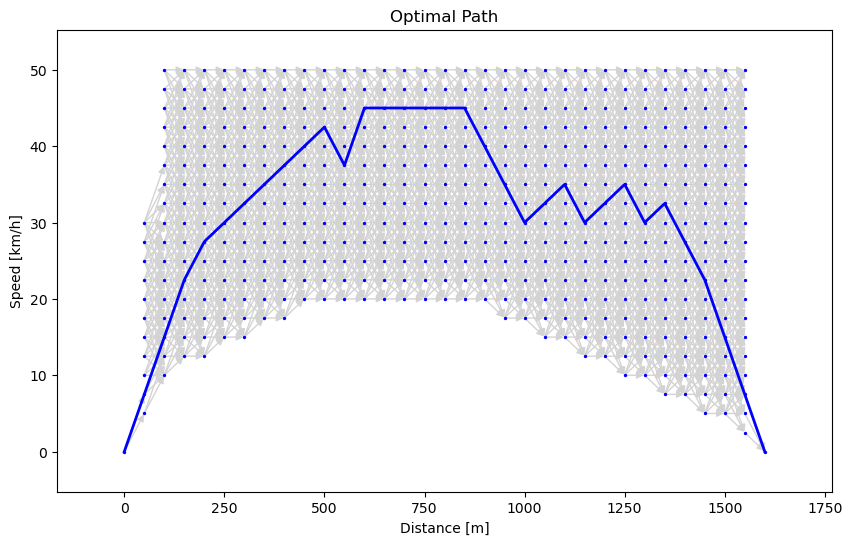

In [26]:
"""
matrix = nx.to_pandas_adjacency(G)
matrix.to_csv("AdjMatrix.csv", sep=',')
"""


weight_list = []
attributelist = nx.get_edge_attributes(G,'weight')
for edge in G.edges:
    weight_list.append(attributelist[edge])


fig, ax = plt.subplots(figsize=(10, 6))

nx.draw(
    G,
    pos=coordinate_set_dict,
    ax=ax,
    with_labels=False,
    node_color='blue',
    edge_color='lightgrey',
    node_size=2,
)
ax.plot(output['distance'], output['Speed optimal'], color='blue', linewidth=2, label='Optimal Speed')
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Speed [km/h]')
ax.set_title('Optimal Path')
ax.axis('on')
plt.tick_params(axis='both', which='both', bottom=True, left=True, labelbottom=True, labelleft=True)
plt.show()
